In [ ]:
# model 2

In [1]:
import os
import subprocess
import pickle
import lmdb
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from tqdm import tqdm
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  
import warnings
warnings.filterwarnings(action='ignore')
from multiprocessing import Pool


def smi2_2Dcoords(smi):
    mol = Chem.MolFromSmiles(smi)
    mol = AllChem.AddHs(mol)
    AllChem.Compute2DCoords(mol)
    coordinates = mol.GetConformer().GetPositions().astype(np.float32)
    len(mol.GetAtoms()) == len(coordinates), "2D coordinates shape is not align with {}".format(smi)
    return coordinates

def smi2_3Dcoords(smi,cnt):
    mol = Chem.MolFromSmiles(smi)
    mol = AllChem.AddHs(mol)
    coordinate_list=[]
    for seed in range(cnt):
        try:
            res = AllChem.EmbedMolecule(mol, randomSeed=1)  # will random generate conformer with seed equal to -1. else fixed random seed.
            if res == 0:
                try:
                    AllChem.MMFFOptimizeMolecule(mol)       # some conformer can not use MMFF optimize
                    coordinates = mol.GetConformer().GetPositions()
                except:
                    print("Failed to generate 3D, replace with 2D")
                    coordinates = smi2_2Dcoords(smi)            
                    
            elif res == -1:
                mol_tmp = Chem.MolFromSmiles(smi)
                AllChem.EmbedMolecule(mol_tmp, maxAttempts=5000, randomSeed=1)
                mol_tmp = AllChem.AddHs(mol_tmp, addCoords=True)
                try:
                    AllChem.MMFFOptimizeMolecule(mol_tmp)       # some conformer can not use MMFF optimize
                    coordinates = mol_tmp.GetConformer().GetPositions()
                except:
                    print("Failed to generate 3D, replace with 2D")
                    coordinates = smi2_2Dcoords(smi) 
        except:
            print("Failed to generate 3D, replace with 2D")
            coordinates = smi2_2Dcoords(smi) 

        assert len(mol.GetAtoms()) == len(coordinates), "3D coordinates shape is not align with {}".format(smi)
        coordinate_list.append(coordinates.astype(np.float32))
    return coordinate_list

def inner_smi2coords(smiles):
    smi = smiles
    # ori_index = content[1]
    target = 0
    cnt = 1 # conformer num,all==11, 10 3d + 1 2d

    mol = Chem.MolFromSmiles(smi)
    if len(mol.GetAtoms()) > 400:
        coordinate_list =  [smi2_2Dcoords(smi)] * (cnt+1)
        print("atom num >400,use 2D coords",smi)
    else:
        coordinate_list = smi2_3Dcoords(smi,cnt)
        coordinate_list.append(smi2_2Dcoords(smi).astype(np.float32))
    mol = AllChem.AddHs(mol)
    atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]  # after add H 
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    scaffold_smiles = Chem.MolToSmiles(scaffold)
    return pickle.dumps({'atoms': atoms, 'coordinates': coordinate_list, 'smi': smi, 'target': target
                        }, protocol=-1)

def smi2coords(smiles_list):
    try:
        return inner_smi2coords(smiles_list)
    except:
        print("failed smiles: {}".format(smiles_list[0]))
        return None

def write_lmdb(smiles_list, job_name, outpath='./results', nthreads=16):
    os.makedirs(outpath, exist_ok=True)
    output_name = os.path.join(outpath,'{}.lmdb'.format(job_name))
    try:
        os.remove(output_name)
    except:
        pass
    env_new = lmdb.open(
        output_name,
        subdir=False,
        readonly=False,
        lock=False,
        readahead=False,
        meminit=False,
        max_readers=1,
        map_size=int(100e9),
    )
    txn_write = env_new.begin(write=True)
    with Pool(nthreads) as pool: # 创建线程池，用于并行处理数据
        i = 0
        for inner_output in pool.imap(smi2coords, smiles_list):
            if inner_output is not None:
                txn_write.put(f'{i}'.encode("ascii"), inner_output) # 将处理后的数据写入LMDB事务
                i += 1
        txn_write.commit()
        env_new.close()


# smi_list = [
#     'c3ccc(c1ccccc1c2ccccc2)cc3'
# # 'N(c1ccc2c3c1cccc3CC2)(c1c2c(cccc2)c(N(c2ccc3c4c2cccc4CC3)c2ccc3c(c2)c2c(o3)cccc2)c2c1cccc2)c1cc2c3ccccc3oc2cc1'
    
# # 'c1c(cc(cc1c1c2c(c(c3c1cccc3)c1c3c(ccc1)cccc3)cccc2)c1ccc(c2c3c(c(c4c2cccc4)c2c4c(ccc2)cccc4)cccc3)cc1)c1c2c(c(c3c1cccc3)c1c3c(ccc1)cccc3)cccc2'
# ]

smi_list = ['CC1=CC=C2C(=C1)B1C3=C(N2C2=CC=C4C(=C2)C2=CC=CC=C2O4)C=C(C=C3N(C2=C1SC1=C2C(=CC=C1)N(C1=CC=CC=C1)C1=CC=CC=C1)C1=CC=CC(=C1)C(C)(C)C)N(C1=CC=CC=C1)C1C=CC=CC=1', 
            'CC1C=CC2=C(C=1)B1C3SC4C(C=3N(C3=C1C(N2C1=CC=C2C(=C1)OC1C2=CC=CC=1)=CC(=C3)N(C1=CC=CC=C1)C1C=CC=CC=1)C1=CC=CC(=C1)C(C)(C)C)=CC(=CC=4)N(C1=CC=CC=C1)C1C=CC=CC=1', 
            'CC1=CC2N(C3C=CC(=CC=3)C(C)(C)C)C3C=CC(=CC=3B3C=2C(=C1)N1C2C=CC(=CC=2C2=C4C1=C3SC4=CC(=C2)C(C)(C)C)C(C)(C)C)C(C)(C)C', 
            'CC(C1C=CC=C(C=1)N1C(=NC2C1=CC1N(C3C=C(C=C4C=3B(C=1C=2)C1SC2=C(C=1N4C1=CC=CC(=C1)C(C)(C)C)C=CC=C2)N1C2C=CC=CC=2C2C1=CC=CC=2)C1=CC=CC2=C1C1C=CC=CC=1S2)C1C=CC2=C(C=1)C1=CC=CC=C1S2)(C)C', 
            'C1C=C2C3=C(C=1)N1C4=CC=CC=C4C4C1=C(B3C1C3N2C2=CC=CC=C2C=3C=CC=1)C=CC=4', 
            'CC(C1=CC=CC(=C1)N1C2=CC(=CC=C2B2C3=C1C=CC=C3N(C1=C2SC2C1=CC=CC=2N(C1C=CC=CC=1)C1C=CC=CC=1)C1=CC=CC(=C1)C(C)(C)C)N(C1=CC=CC=C1)C1C=CC=CC=1)(C)C', 
            'CC1=CC=C2C(=C1)N(C1=CC=C3C(=C1)C=CO3)C1C3B2C2C=CC(=CC=2N(C=3C=CC=1)C1=CC=C2C(=C1)C=CO2)C', 
            'C1C=C2N3C4C(C5C3=CC=C(C=5)C3C=CC=C5C=3SC3=C5C=CC=C3)=CC=CC=4B3C2=C(C=1)N1C2C=CC=CC=2C2C1=C3C=CC=2', 
            'CC1C=C(C)C(=C(C=1)C)B1C2C=CC=C3C=2N(C2C1=CC=CC=2)C1=C(B3C2=C(C)C=C(C=C2C)C)C=CC=C1', 
            'CC(C1=CC=C2C(=C1)C1=C(S2)B2C3C=CC(=CC=3N(C3=C2C(N1C1C=CC=C(C=1)C(C)(C)C)=CC(=C3)N(C1C=CC=CC=1)C1C=CC=CC=1)C1=CC=CC2=C1C1=CC=CC=C1S2)N(C1C=CC=CC=1)C1=CC=CC=C1)(C)C', 
            'CC(C1=CC=CC(=C1)N1C2=CC(=CC3=C2B(C2=C1C1=CC(=CC=C1S2)C(C)(C)C)C1=C(N3C2=CC=C3C(=C2)C2C=CC=CC=2S3)C=C(C=C1)N(C1=CC=CC=C1)C1=CC=CC=C1)N(C1C=CC=CC=1)C1=CC=CC=C1)(C)C', 
            'CC(C1C=CC=C(C=1)N1C2C=C(C=CC=2B2C3=C1C=CC=C3N(C1=C2SC2=C1C(=CC=C2)N(C1=CC=CC=C1)C1C=CC=CC=1)C1C=CC=C2C=1C=CC=C2)N(C1C=CC=CC=1)C1=CC=CC=C1)(C)C', 
            'CC1C=CC2=C(C=1)C1=C(S2)B2C3C=CC(=CC=3N(C3=C2C(N1C1=CC=CC(=C1)C(C)(C)C)=CC(=C3)N(C1C=CC=CC=1)C1=CC=CC=C1)C1C=CC2=C(C=1)OC1=C2C=CC=C1)N(C1C=CC=CC=1)C1C=CC=CC=1', 
            'CC(C1C=CC=C(C=1)N1C2C=C(C=CC=2B2C3C1=CC=CC=3N(C1=C2SC2=C1C=C(C=C2)N(C1C=CC=CC=1)C1C=CC=CC=1)C1=CC=CC2=C1C1C=CC=CC=1O2)N(C1=CC=CC=C1)C1=CC=CC=C1)(C)C', 
            'CC(C1C=CC(=CC=1)N1C2C=C(C=CC=2B2C3C1=CC=CC=3N(C1C2=CC=C(C=1)N(C1=CC=C2C(=C1)C1=CC=CC=C1O2)C1C=CC(=CC=1)C(C)(C)C)C1C=CC(=CC=1)C(C)(C)C)N(C1=CC=C2C(=C1)C1=CC=CC=C1O2)C1C=CC(=CC=1)C(C)(C)C)(C)C', 
            'CC1=CC=C2C(=C1)C1=C(S2)B2C3C=CC(=CC=3N(C3=C2C(N1C1=CC=CC(=C1)C(C)(C)C)=CC(=C3)N(C1=CC=CC=C1)C1C=CC=CC=1)C1=CC=C2C(=C1)C1=CC=CC=C1O2)N(C1=CC=CC=C1)C1=CC=CC=C1', 
            'CC(C1C=CC=C(C=1)N1C(=NC2C1=CC1N(C3C=C(C=C4C=3B(C=1C=2)C1SC2=C(C=1N4C1C=CC=C(C=1)C(C)(C)C)C=CC=C2)N1C2=CC=CC=C2C2=C1C=CC=C2)C1=CC=CC2=C1C1C=CC=CC=1S2)C1=CC=C2C(=C1)OC1=C2C=CC=C1)(C)C', 
            'CC(C1=CC=CC(=C1)N1C(=NC2C1=CC1=C(C=2)B2C3SC4=C(C=3N(C3C2=C(N1C1=CC=CC2=C1C1C=CC=CC=1S2)C=C(C=3)N1C2=CC=CC=C2C2=C1C=CC=C2)C1C=CC=C(C=1)C(C)(C)C)C=CC=C4)C1C=CC=C2C=1C=CC=C2)(C)C', 
            'CC(C1C=CC=C(C=1)N1C2C=C3N(C4=CC=CC5=C4B(C3=CC=2N=C1C1=CC=CC2=C1OC1=C2C=CC=C1)C1SC2C(C=1N5C1C=CC=C(C=1)C(C)(C)C)=CC=CC=2)C1C=CC2=C3C=1C=CC1=C3C(C=C2)=CC=C1)(C)C', 
            'CC(C1C=CC(=CC=1)N(C1=CC2N(C3C=CC(=CC=3)C(C)(C)C)C3C=C(C=C4C=3B(C=2C2=C1C1C=CC=CC=1O2)C1C=C(C=CC=1N4C1C=CC(=CC=1)C(C)(C)C)C(C)(C)C)C(C)(C)C)C1=CC=C(C=C1)C(C)(C)C)(C)C']

# smi_list = [
#     "CC1=CC=C2C(=C1)B1C3=C(N2C2=CC=C4C(=C2)C2=CC=CC=C2O4)C=C(C=C3N(C2=C1SC1=C2C(=CC=C1)N(C1=CC=CC=C1)C1=CC=CC=C1)C1=CC=CC(=C1)C(C)(C)C)N(C1=CC=CC=C1)C1C=CC=CC=1",
#     "CC1=CC=C2C(=C1)B1C3=C(N2C2=CC=C4C(=C2)C2=CC=CC=C2O4)C=C(C=C3N(C2=C1SC1=C2C(=CC=C1)N(C1=CC=CC=C1)C1=CC=CC=C1)C1=CC=CC(=C1)C(C)(C)C)N(C1=CC=CC=C1)C1C=CC=CC=1",
#     "CC1=CC=C2C(=C1)B1C3=C(N2C2=CC=C4C(=C2)C2=CC=CC=C2O4)C=C(C=C3N(C2=C1SC1=C2C(=CC=C1)N(C1=CC=CC=C1)C1=CC=CC=C1)C1=CC=CC(=C1)C(C)(C)C)N(C1=CC=CC=C1)C1C=CC=CC=1",
#     "CC1=CC=C2C(=C1)B1C3=C(N2C2=CC=C4C(=C2)C2=CC=CC=C2O4)C=C(C=C3N(C2=C1SC1=C2C(=CC=C1)N(C1=CC=CC=C1)C1=CC=CC=C1)C1=CC=CC(=C1)C(C)(C)C)N(C1=CC=CC=C1)C1C=CC=CC=1",
#     "CC1=CC=C2C(=C1)B1C3=C(N2C2=CC=C4C(=C2)C2=CC=CC=C2O4)C=C(C=C3N(C2=C1SC1=C2C(=CC=C1)N(C1=CC=CC=C1)C1=CC=CC=C1)C1=CC=CC(=C1)C(C)(C)C)N(C1=CC=CC=C1)C1C=CC=CC=1",
#     "CC1=CC=C2C(=C1)B1C3=C(N2C2=CC=C4C(=C2)C2=CC=CC=C2O4)C=C(C=C3N(C2=C1SC1=C2C(=CC=C1)N(C1=CC=CC=C1)C1=CC=CC=C1)C1=CC=CC(=C1)C(C)(C)C)N(C1=CC=CC=C1)C1C=CC=CC=1",
#     "CC1=CC=C2C(=C1)B1C3=C(N2C2=CC=C4C(=C2)C2=CC=CC=C2O4)C=C(C=C3N(C2=C1SC1=C2C(=CC=C1)N(C1=CC=CC=C1)C1=CC=CC=C1)C1=CC=CC(=C1)C(C)(C)C)N(C1=CC=CC=C1)C1C=CC=CC=1",
#     "CC1=CC=C2C(=C1)B1C3=C(N2C2=CC=C4C(=C2)C2=CC=CC=C2O4)C=C(C=C3N(C2=C1SC1=C2C(=CC=C1)N(C1=CC=CC=C1)C1=CC=CC=C1)C1=CC=CC(=C1)C(C)(C)C)N(C1=CC=CC=C1)C1C=CC=CC=1",
#     "CC1=CC=C2C(=C1)B1C3=C(N2C2=CC=C4C(=C2)C2=CC=CC=C2O4)C=C(C=C3N(C2=C1SC1=C2C(=CC=C1)N(C1=CC=CC=C1)C1=CC=CC=C1)C1=CC=CC(=C1)C(C)(C)C)N(C1=CC=CC=C1)C1C=CC=CC=1",
#     "CC1=CC=C2C(=C1)B1C3=C(N2C2=CC=C4C(=C2)C2=CC=CC=C2O4)C=C(C=C3N(C2=C1SC1=C2C(=CC=C1)N(C1=CC=CC=C1)C1=CC=CC=C1)C1=CC=CC(=C1)C(C)(C)C)N(C1=CC=CC=C1)C1C=CC=CC=1"
# ]

job_name = 'molecule' # lmdb filename
molecular_path='./molecule_file' # path that lmdb file saved
data_path='./'  # replace to your data path
results_path= './'  # replace to your results path
weight_path='./BN648_cam_b3lyp_checkpoint_best.pt'  # replace to your ckpt path
predict_path=f"./{job_name}.out.pkl"  # replace to your results path
batch_size=32
task_name='molecule_file' # data folder name 
task_num=5
loss_func='finetune_smooth_mae'
dict_name='dict.txt'
conf_size=1
only_polar=0
i=0


write_lmdb(smi_list, job_name=job_name, outpath=molecular_path, nthreads=96)
# !CUDA_VISIBLE_DEVICES="cpu" python ./one_molecular_infer.py --user-dir ../../unimol $data_path \
#        --task-name $task_name --valid-subset $job_name \
#        --results-path $results_path \
#        --num-workers 8 --ddp-backend=c10d --batch-size $batch_size \
#        --task mol_finetune --loss $loss_func --arch unimol_base \
#        --classification-head-name BN_648_cam_b3lyp --num-classes $task_num \
#        --dict-name $dict_name --conf-size $conf_size \
#        --only-polar $only_polar  \
#        --path $weight_path  \
#        --fp16 --fp16-init-scale 4 --fp16-scale-window 256 \
#        --log-interval 50 -w-log-format simple 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
process = subprocess.Popen(["python","./one_molecular_infer_new.py","--user-dir","./unimol",data_path,"--task-name",task_name,
                            "--valid-subset",job_name,"--results-path",results_path,"--num-workers","8","--ddp-backend","c10d",
                            "--batch-size",str(batch_size),"--task","mol_finetune","--loss",loss_func,"--arch","unimol_base",
                            "--classification-head-name","BN_648_cam_b3lyp","--num-classes",str(task_num),"--dict-name",dict_name,"--conf-size",
                            str(conf_size),"--only-polar",str(only_polar),"--path",weight_path,"--fp16","--fp16-init-scale","4",
                            "--fp16-scale-window","256","--log-interval","50","--log-format","simple"],stdout=subprocess.PIPE)
output,error = process.communicate()
print(output[173:])
# return output[173:]

if len(smi_list)==1 :
    Draw.MolsToGridImage([Chem.MolFromSmiles(smi_list[0])], subImgSize=(400, 400))

b'                                               SMILES  ...      HOMO\n0   CC1=CC=C2C(=C1)B1C3=C(N2C2=CC=C4C(=C2)C2=CC=CC...  ... -4.991868\n1   CC1C=CC2=C(C=1)B1C3SC4C(C=3N(C3=C1C(N2C1=CC=C2...  ... -4.846696\n2   CC(C1=CC=CC(=C1)N1C2=CC(=CC3=C2B(C2=C1C1=CC(=C...  ... -4.814678\n3   CC(C1C=CC=C(C=1)N1C2C=C(C=CC=2B2C3=C1C=CC=C3N(...  ... -4.901838\n4   CC1C=CC2=C(C=1)C1=C(S2)B2C3C=CC(=CC=3N(C3=C2C(...  ... -4.827291\n5   CC(C1C=CC=C(C=1)N1C2C=C(C=CC=2B2C3C1=CC=CC=3N(...  ... -4.836994\n6   CC(C1C=CC(=CC=1)N1C2C=C(C=CC=2B2C3C1=CC=CC=3N(...  ... -4.776192\n7   CC1=CC=C2C(=C1)C1=C(S2)B2C3C=CC(=CC=3N(C3=C2C(...  ... -4.820985\n8   CC(C1C=CC=C(C=1)N1C(=NC2C1=CC1N(C3C=C(C=C4C=3B...  ... -4.964014\n9   CC(C1=CC=CC(=C1)N1C(=NC2C1=CC1=C(C=2)B2C3SC4=C...  ... -4.934906\n10  CC(C1C=CC=C(C=1)N1C2C=C3N(C4=CC=CC5=C4B(C3=CC=...  ... -4.700029\n11  CC(C1C=CC(=CC=1)N(C1=CC2N(C3C=CC(=CC=3)C(C)(C)...  ... -4.832142\n12  CC1=CC2N(C3C=CC(=CC=3)C(C)(C)C)C3C=CC(=CC=3B3C...  ... -4.797052\n13  CC(C1C=CC=C(C=

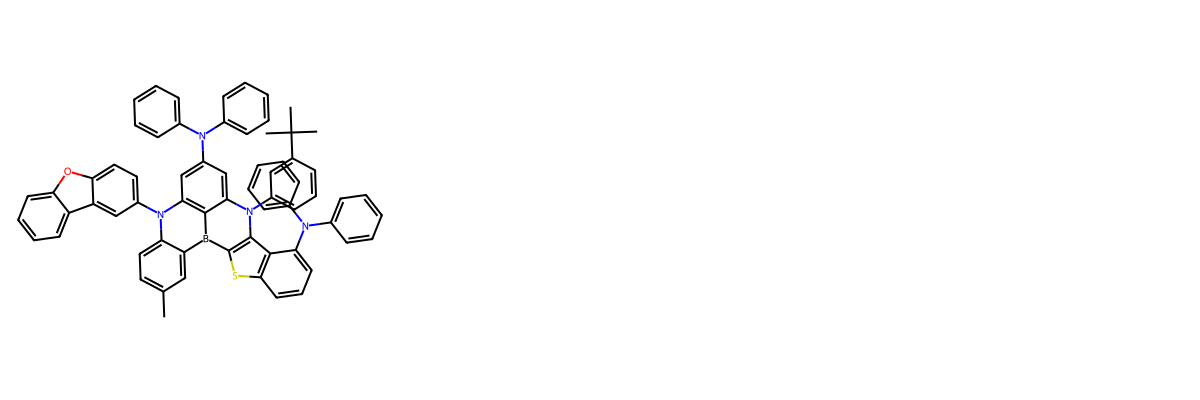

In [25]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi_list[0])], subImgSize=(400, 400))